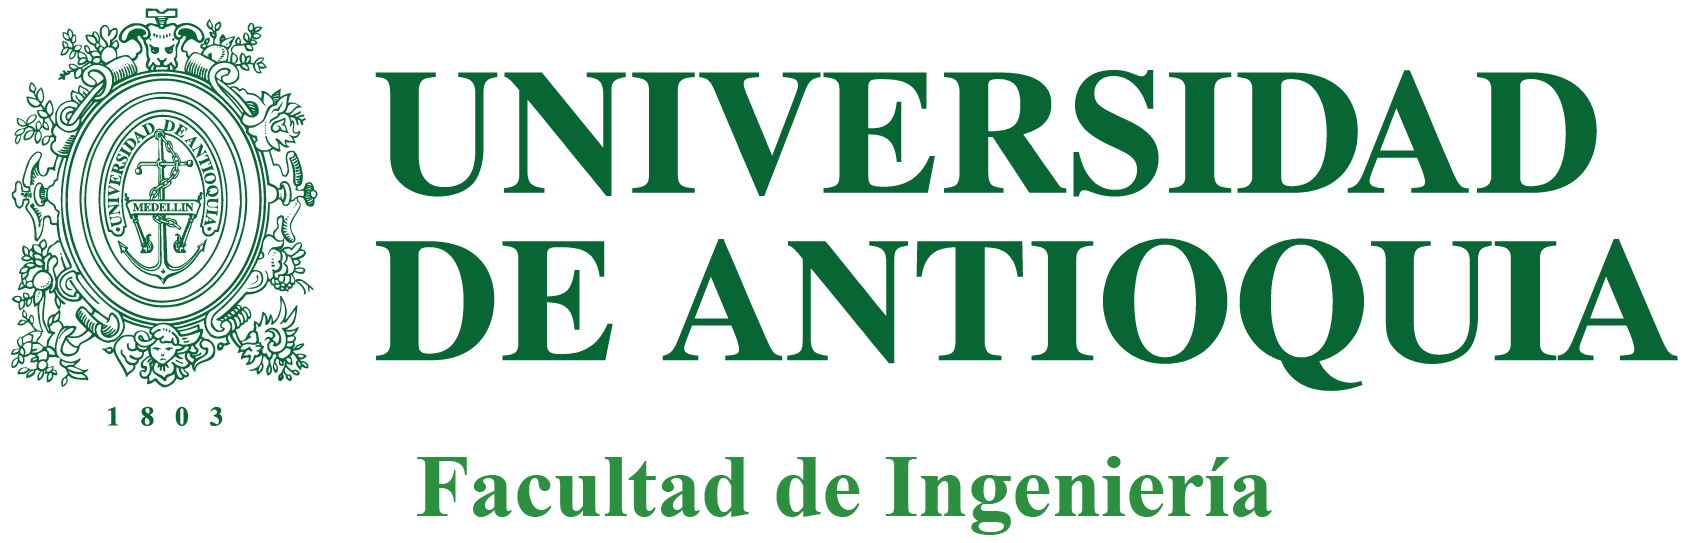
---

**Especialización en Analítica y Ciencia de Datos - Analytics & Data Science**

**Universidad de Antioquia**

**2024**

**Melissa Ortega Alzate**

---

# Redes neuronales convolucionales para la detección de Salmonella *spp.* en aves de corral
### Convolutional Neural Networks for the Detection of Salmonella spp. in Poultry

This notebook is the third part of a series of three notebooks associated with the project "Convolutional Neural Networks for the Detection of Salmonella spp. in Poultry". The other notebooks can be found in the associated GitHub repository linked below.

<div style="display: flex; align-items: center; justify-content: flex-end; position: fixed; bottom: 10px; right: 10px;">
  <a href="https://colab.research.google.com/github/tu-usuario/tu-repositorio" style="margin-right: 15px;">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" style="height: 25px;">
  </a>
  <a href="https://github.com/melissaortegaa/monografia" style="margin-right: 15px;">
    <img src="https://img.shields.io/badge/GitHub-000?logo=github&logoColor=fff&style=flat" alt="View on GitHub" style="height: 25px;">
  </a>
  <a href="https://www.kaggle.com/code/melissaortegaalzate/04-transfer-learning-ipynb">
    <img src="https://img.shields.io/badge/Kaggle-20BEFF?logo=kaggle&logoColor=fff&style=flat" alt="View on Kaggle" style="height: 25px;">
  </a>
</div>

## Summary


## Objective



# Init

### Imports

In [99]:
# Standard library imports
import os
import sys
import random
import zipfile
import warnings
import time
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data manipulation and processing
import numpy as np
import pandas as pd

# Deep learning frameworks and utilities
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras import backend as K

# Callbacks, regularizer and optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.optimizers import Adam, RMSprop

# Model evaluation
from sklearn.metrics import confusion_matrix, classification_report

# Ignore Warnings
warnings.filterwarnings("ignore")

# Clear any previous Keras session to avoid clutter from old models
K.clear_session()

# Set environment variables to reduce TensorFlow verbosity and CUDA issues
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Confirmation
print('\nThe modules were successfully loaded.')


The modules were successfully loaded.


In [100]:
# Google Drive connection
!pip install -q gdown
import gdown
print('gdown was successfully installed and imported.')

gdown was successfully installed and imported.


### Tensorflow and devices settings

In [101]:
# System configuration
if 'google.colab' in sys.modules:
    print("Setting TensorFlow version in Colab")
    %tensorflow_version 2.x

# Check TensorFlow version
print(f'TensorFlow version: {tf.__version__}')

TensorFlow version: 2.15.0


In [102]:
# GPU configuration
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU.')
    try:
        for gpu in gpu_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpu_devices)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print('Using CPU.')

Using GPU.
1 Physical GPUs, 1 Logical GPUs


In [103]:
# Hardware devices info
!nvidia-smi

Wed May 29 03:31:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0              33W / 250W |   8604MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [104]:
# Create a directory to store the results if it doesn't exist
results_path = Path('results', 'transfer_learning')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [105]:
# Fixing the random seeds for reproducibility
np.random.seed(0)         # NumPy random seed
tf.random.set_seed(0)     # TensorFlow random seed
random.seed(0)            # Python random seed

print("Random seeds are set for reproducibility.")

Random seeds are set for reproducibility.


# Functions

**Function to plot activation maps of a given model layer**

In [106]:
# Function to plot activation maps of a given model layer
def plot_activations(model, layer_name,image_batch,label_batch, n_images=5, n_channels=10):
    """
    Plots the activations of a given intermediate layer for a batch of input images.

    Parameters:
    model: keras.Model - The model to extract the activations from.
    layer_name: str - The name of the intermediate layer to extract the activations from.
    train_generator: keras.utils.Sequence - The data generator for providing input images.
    n_images: int, optional - The number of input images to plot the activations for. Default is 5.
    n_channels: int, optional - The number of channels to plot. Default is 10.

    Returns:
    fig: matplotlib.figure.Figure - The figure containing the activation plots.
    """
    # Create a new model that includes the model and the intermediate layer
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

    # Ensure we only process the desired number of images
    image_batch = image_batch[:n_images]
    label_batch = label_batch[:n_images]

    # Print labels to check for variety
    print("Labels of selected images:", label_batch)

    # Extract the activations of the intermediate layer for the input images
    activations = intermediate_layer_model.predict(image_batch)
    num_channels = min(activations.shape[-1], n_channels)

    # Plot the activations for a subset of the input images
    fig, axes = plt.subplots(n_images, num_channels + 1, figsize=(2 * (num_channels + 1), 2 * n_images))
    for i in range(n_images):
        ax = axes[i, 0]
        ax.imshow(image_batch[i])
        ax.axis("off")
        for j in range(num_channels):
            ax = axes[i, j + 1]
            act = activations[i, :, :, j]
            ax.imshow(act, cmap=plt.cm.Greys_r)
            ax.axis("off")
    return fig

**Function to plot history of training**

In [107]:
# Function to plot history of training
def plot_history(history, title='Model training history'):
    """
    Function to plot the training history of a model.
    
    Parameters:
    history: History object returned by the Keras fit method.
    title (str): Title for the plot.
    
    """
    # Convert the history to a DataFrame
    hist = pd.DataFrame.from_dict(history.history)
    hist['epoch'] = history.epoch
    max_epoch = hist['epoch'].max()
    
    # Determine if recall columns exist
    recall_columns = [col for col in hist.columns if 'recall' in col]
    num_plots = 3 if len(recall_columns) >= 2 else 2
    
    # Found best epochs
    val_lowest_index = hist['val_loss'].idxmin()
    val_lowest = hist['val_loss'].min()
    index_loss = hist['epoch'][val_lowest_index]
    
    val_max_index = hist['val_accuracy'].idxmax()
    val_max = hist['val_accuracy'].max()
    index_acc = hist['epoch'][val_max_index]
    
    loss_label = f'best epoch= {index_loss + 1}'
    acc_label = f'best epoch= {index_loss + 1}'

    # Create figure and axes
    fig, axes = plt.subplots(1, num_plots, figsize=(18, 6))
    fig.suptitle(title, fontsize=13,  fontweight='bold')

    # Ensure axes is always a list, even with a single subplot
    if num_plots == 1:
        axes = [axes]

    # Plot loss
    axes[0].plot(hist['epoch'], hist['loss'], 'o-r', label='Training')
    axes[0].plot(hist['epoch'], hist['val_loss'], '--', label='Validation')
    axes[0].set_xlim([0, max_epoch + 2])
    axes[0].set_ylim([0, max(hist['loss'].max(), hist['val_loss'].max()) * 1.1])
    axes[0].scatter(index_loss, val_lowest,s=60, c='green', label=loss_label)
    axes[0].set(ylabel='Loss', xlabel="Epochs")
    axes[0].set_title("Loss", fontweight='bold')

    # Plot accuracy
    axes[1].plot(hist['epoch'], hist['accuracy'], 'o-r', label='Training')
    axes[1].plot(hist['epoch'], hist['val_accuracy'], '--', label='Validation')
    axes[1].set_xlim([0, max_epoch + 2])
    axes[1].scatter(index_acc, val_max, s=60, c='green', label=acc_label)
    axes[1].set_ylim([hist['accuracy'].min() - 0.1, 1])
    axes[1].set(ylabel='Accuracy', xlabel="Epochs")
    axes[1].set_title('Accuracy', fontweight='bold')

    # Plot Recall (optional)
    if num_plots == 3:
        axes[2].plot(hist['epoch'], hist[recall_columns[0]], 'o-r', label='Training')
        axes[2].plot(hist['epoch'], hist[recall_columns[1]], '--', label='Validation')
        axes[2].set_xlim([0, max_epoch + 2])
        axes[2].set_ylim(([hist['accuracy'].min() - 0.1, 1]))
        axes[2].set(ylabel='Recall', xlabel="Epochs")
        axes[2].set_title("Recall", fontweight='bold')
        axes[2].set_xticks(range(max_epoch + 1))
        axes[2].legend()

    # Adjust space between subplots and general title
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)

    # Show the plot
    plt.show();

**Callbacks**

In [108]:
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.times = []
    
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = time.time()
    
    def on_epoch_end(self, epoch, logs=None):
        self.times.append(time.time() - self.epoch_time_start)

In [109]:
# Function to plot history of training
def plot_history(history, title='Model training history'):
    """
    Function to plot the training history of a model.
    
    Parameters:
    history: History object returned by the Keras fit method.
    title (str): Title for the plot.
    
    """
    # Convert the history to a DataFrame
    hist = pd.DataFrame.from_dict(history.history)
    hist['epoch'] = history.epoch
    max_epoch = hist['epoch'].max()
    
    # Determine if recall columns exist
    recall_columns = [col for col in hist.columns if 'recall' in col]
    num_plots = 3 if len(recall_columns) >= 2 else 2
    
    # Found best epochs
    val_lowest_index = hist['val_loss'].idxmin()
    val_lowest = hist['val_loss'].min()
    index_loss = hist['epoch'][val_lowest_index]

    val_max_index = hist['val_accuracy'].idxmax()
    val_max = hist['val_accuracy'].max()
    index_acc = hist['epoch'][val_max_index]

    val_recall_max_index = hist['val_recall'].idxmax()
    val_recall_max = hist['val_recall'].max()
    index_recall = hist['epoch'][val_recall_max_index]

    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    recall_label = f'best epoch= {str(index_recall + 1)}'

    # Create figure and axes
    fig, axes = plt.subplots(1, num_plots, figsize=(18, 6))
    fig.suptitle(title, fontsize=13,  fontweight='bold')

    # Ensure axes is always a list, even with a single subplot
    if num_plots == 1:
        axes = [axes]

    # Plot loss
    axes[0].plot(hist['epoch'], hist['loss'], 'o-r', label='Training')
    axes[0].plot(hist['epoch'], hist['val_loss'], '--', label='Validation')
    axes[0].set_xlim([0, max_epoch + 2])
    axes[0].set_ylim([0, max(hist['loss'].max(), hist['val_loss'].max()) * 1.1])
    axes[0].scatter(index_loss, val_lowest,s=60, c='green', label=loss_label)
    axes[0].set(ylabel='Loss', xlabel="Epochs")
    axes[0].set_title("Loss", fontweight='bold')
    axes[0].legend()

    # Plot accuracy
    axes[1].plot(hist['epoch'], hist['accuracy'], 'o-r', label='Training')
    axes[1].plot(hist['epoch'], hist['val_accuracy'], '--', label='Validation')
    axes[1].set_xlim([0, max_epoch + 2])
    axes[1].scatter(index_acc, val_max, s=60, c='green', label=acc_label)
    axes[1].set_ylim([hist['accuracy'].min() - 0.1, 1])
    axes[1].set(ylabel='Accuracy', xlabel="Epochs")
    axes[1].set_title('Accuracy', fontweight='bold')
    axes[1].legend()

    # Plot Recall (optional)
    if num_plots == 3:
        axes[2].plot(hist['epoch'], hist[recall_columns[0]], 'o-r', label='Training')
        axes[2].plot(hist['epoch'], hist[recall_columns[1]], '--', label='Validation')
        axes[2].set_xlim([0, max_epoch + 2])
        axes[2].set_ylim(([hist['accuracy'].min() - 0.1, 1]))
        axes[2].scatter(index_recall, val_recall_max, s=60, c='green', label=recall_label)
        axes[2].set(ylabel='Recall', xlabel="Epochs")
        axes[2].set_title("Recall", fontweight='bold')
        axes[2].set_xticks(range(max_epoch + 1))
        axes[2].legend()

    # Adjust space between subplots and general title
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)

    # Show the plot
    plt.show()


**Function to create confusion matrix**

In [110]:
# Function to create confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.YlGnBu):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create the confusion matrix
    sns.heatmap(cm, cmap=cmap, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes)

    # Styling
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show();

    # Return the confusion matrix
    return cm

# Load the dataset

In [111]:
# Download the preprocessed zip file from Google Drive
!gdown '13G-XzLgJx_94ZER7yT1j4lCK_srx2jQp' -O \
    /tmp/data1.zip

Downloading...
From (original): https://drive.google.com/uc?id=13G-XzLgJx_94ZER7yT1j4lCK_srx2jQp
From (redirected): https://drive.google.com/uc?id=13G-XzLgJx_94ZER7yT1j4lCK_srx2jQp&confirm=t&uuid=24f44db1-4e5d-4bd6-ab59-4371291e66f1
To: /tmp/data1.zip
100%|█████████████████████████████████████████| 172M/172M [00:00<00:00, 183MB/s]


In [112]:
# Define the path of the ZIP file and the extraction directory
local_zip = '/tmp/data1.zip'
extract_dir = '/tmp/data'

# Extract files from the ZIP archive
try:
    with zipfile.ZipFile(local_zip, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("Extraction completed successfully.")
except Exception as e:
    print("Error during extraction:", e)

Extraction completed successfully.


In [113]:
# Define directories
base_dir = '/tmp/data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Define subdirectories for each class
train_healthy_dir = os.path.join(train_dir, 'healthy')
train_salmo_dir = os.path.join(train_dir, 'salmo')

validation_healthy_dir = os.path.join(validation_dir, 'healthy')
validation_salmo_dir = os.path.join(validation_dir, 'salmo')

test_healthy_dir = os.path.join(test_dir, 'healthy')
test_salmo_dir = os.path.join(test_dir, 'salmo')

# Get lists of files in each folder
train_healthy_fnames = os.listdir(train_healthy_dir)
train_salmo_fnames = os.listdir(train_salmo_dir)

validation_healthy_fnames = os.listdir(validation_healthy_dir)
validation_salmo_fnames = os.listdir(validation_salmo_dir)

test_healthy_fnames = os.listdir(test_healthy_dir)
test_salmo_fnames = os.listdir(test_salmo_dir)

# Print example files names
print(f"Train data examples for 1st class: \n{train_healthy_fnames[:10]}")
print(f"\nTrain data examples for 2nd class: \n{train_salmo_fnames[:10]}")

Train data examples for 1st class: 
['healthy.1251.jpg', 'healthy.1036.jpg', 'healthy.1514.jpg', 'healthy.2004.jpg', 'pcrhealthy.309.jpg', 'healthy.1977.jpg', 'healthy.46.jpg', 'healthy.1989.jpg', 'healthy.1407.jpg', 'healthy.362.jpg']

Train data examples for 2nd class: 
['salmo.1882.jpg', 'salmo.943.jpg', 'salmo.676.jpg', 'salmo.1273.jpg', 'salmo.800.jpg', 'salmo.1599.jpg', 'salmo.1287.jpg', 'salmo.2067.jpg', 'salmo.2092.jpg', 'salmo.117.jpg']


# Data preprocessing and augmentation

In this section, three main transformations are applied to the training and validation images:

* Resizing: All images are resized to 224x224x3.
* Normalization: Images are rescaled to a 1/255 ratio so that all pixels are in a common scale, facilitating the training of the models.
* Augmentation: Rotations, shears, zooms, and flips are added to the training data.

In [114]:
# Define training parameters
IMG_SIZE = 224
EPOCHS = 50          # Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
BATCH_SIZE = 32      # Number of samples per gradient update
STEPS_PER_EPOCH = 20 # Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch
VALIDATION_STEPS = 10

In [115]:
# Transforms will be added to the images to increase the size of the datasets.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches using train_datagen generator for categorical models.
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='rgb',
        seed=42)

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='rgb',
        seed=42)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=False,  # No shuffle for test data
        seed=42)

Found 4023 images belonging to 2 classes.
Found 753 images belonging to 2 classes.
Found 253 images belonging to 2 classes.


# VGG16 transfer learning

Using the VGG16 weights, pre-trained on ImageNet. The the new input size upon import and set all layers to not trainable is defined:

In [116]:
# Create the base model from the pre-trained model VGG16 without top layers

base_model = VGG16(weights='imagenet',         # Load weights pre-treined on ImageNet
                   include_top=False,          # Do nor include the ImageNet classifier at the top
                   input_shape=(IMG_SIZE, IMG_SIZE, 3),
                   )

In [117]:
# Freeze the convolutional base layers to avoid them to update the weights during the training
base_model.trainable = False
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [118]:
# Obtain a batch of images and labels from the training generator
image_batch, label_batch = next(train_generator)

# Verify that the input shape matches the shape of the images in the batch
print("Input shape:", base_model.input_shape)
print("Image batch shape:", image_batch.shape)

# Pass the batch of images through the VGG16 model and obtain the feature vectors
feature_batch = base_model(image_batch)

# Print the shape of the feature vectors
print("Feature batch shape:", feature_batch.shape)

Input shape: (None, 224, 224, 3)
Image batch shape: (32, 224, 224, 3)
Feature batch shape: (32, 7, 7, 512)


This pre-trained model is used as a feature extractor, it converts each 224x224x3 image into a 7x7x512 block of features. An the end 32 characteristics maps are generated. That output will be then used to train some top layers on the dataset to get the predictions.

Labels of selected images: [[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


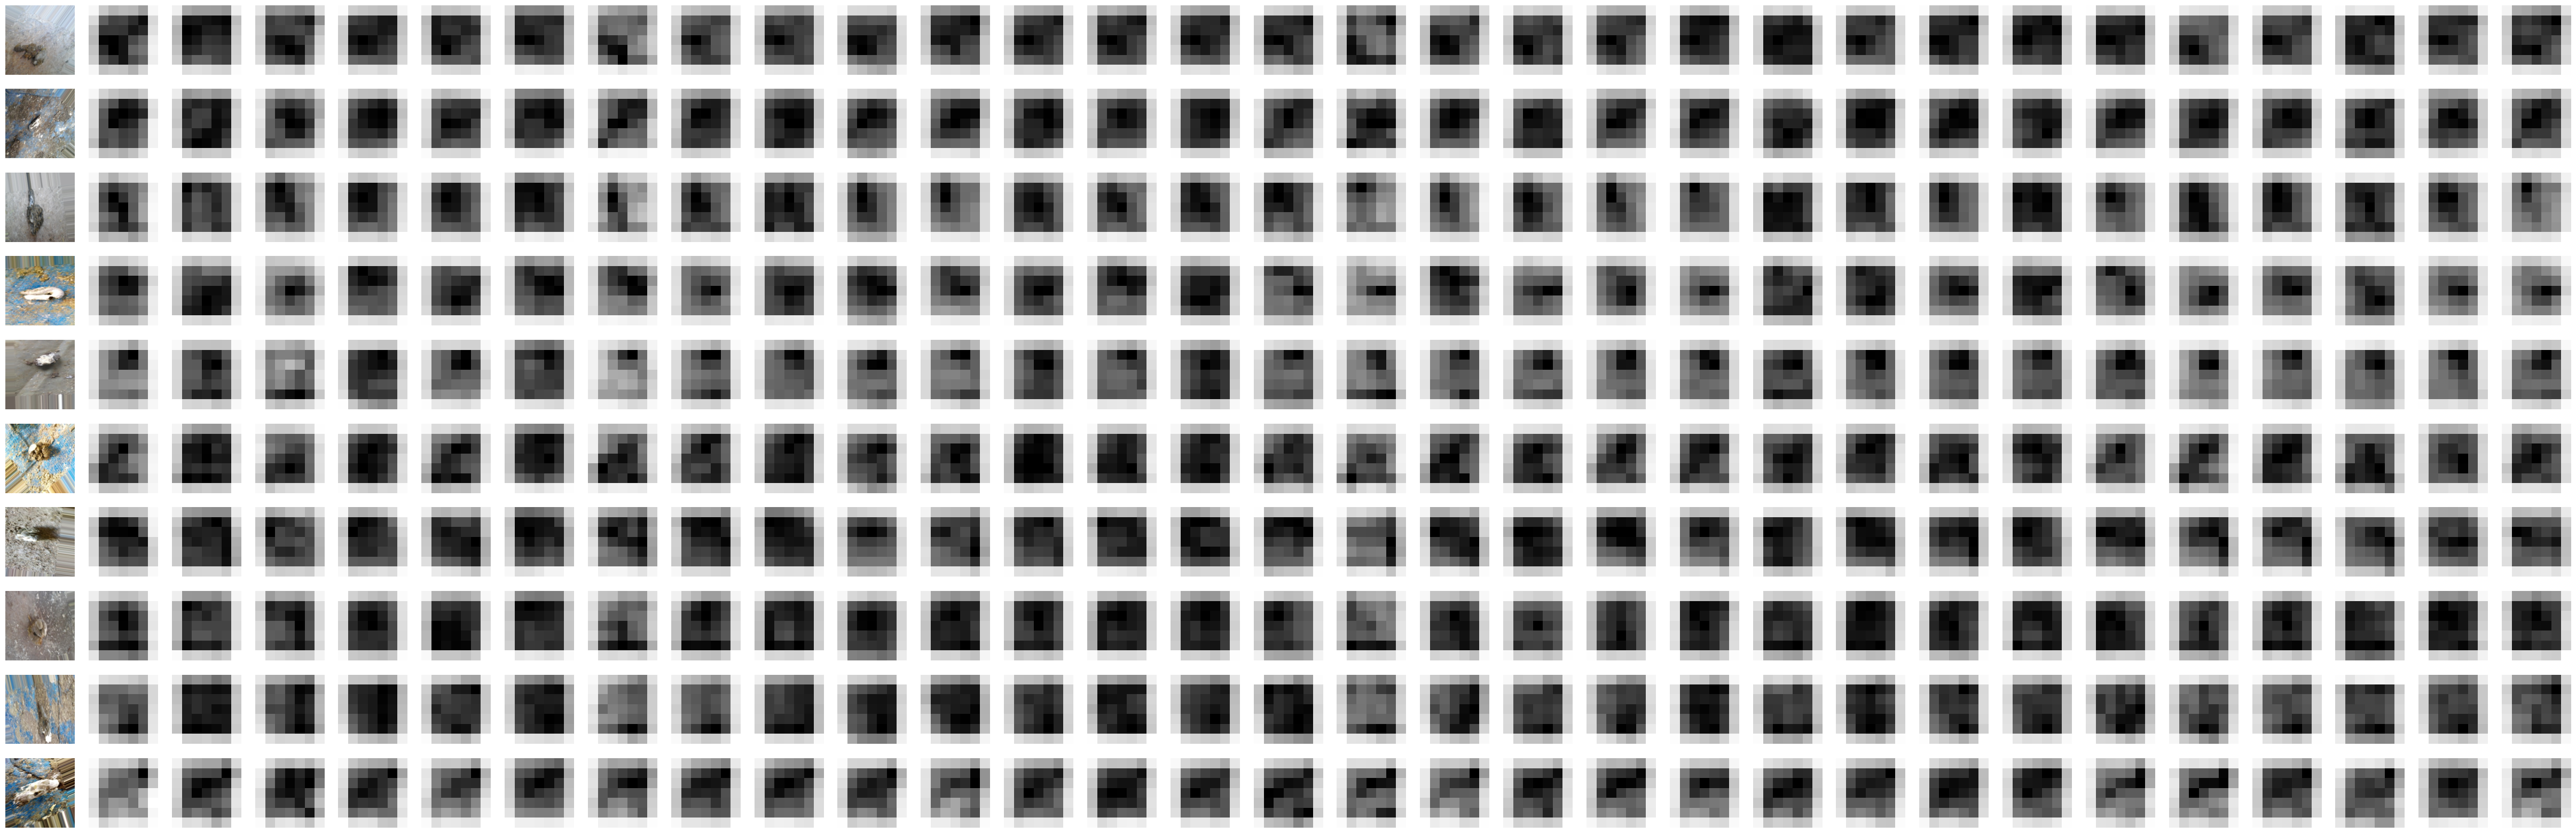

In [119]:
# Generar un lote de datos antes de llamar a plot_activations
image_batch, label_batch = next(train_generator)

# Llamar a plot_activations con el lote de datos generado
fig = plot_activations(base_model, 'block5_pool', image_batch, label_batch, n_images=10, n_channels=30)
plt.show()  # Muestra la figura

## Create the new model by adding new layers to the VGG16 model

Using Keras’ functional API to define the vgg16 output as input into a new set of fully-connected layers like so:

In [122]:
# Adding top custom Layers
x = base_model.output

# Convert features of shape 'base_model.output_shape[1:]' to vectors
x = GlobalAveragePooling2D()(x)

# Adding a dense and dropout layer
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

# Adding a dense classifier with softmax activation
output = Dense(2, activation='softmax')(x)

In [123]:
# Define the new model
transfer_model = Model(inputs=base_model.input, outputs=output)
transfer_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,747,650 (56.26 MB)

 Trainable params: 32,962 (128.76 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [124]:
# Compile the model using the best baseline parameters
transfer_model.compile(loss='categorical_crossentropy',
              optimizer = RMSprop(learning_rate=0.001),
              metrics=['accuracy', tf.keras.metrics.Recall()])

### Callbacks

In [125]:
# Time tracking callback
time_callback = TimeHistory()

# Define early stopping parameters
earlystop = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)

# Define the ModelCheckpoint callback to save the best model based on the validation metric
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

### Train the transfer model

In [126]:
EPOCHS= 2

In [ ]:
# Train the transfer model
history = transfer_model.fit(train_generator,
                            steps_per_epoch = STEPS_PER_EPOCH,
                            epochs = EPOCHS,
                            validation_data = validation_generator,
                            validation_steps = VALIDATION_STEPS,
                            verbose=1,
                            callbacks = [time_callback, earlystop, checkpoint]
                            )

# Save the trained model
transfer_model.save('vgg16_transfer_learning.h5')

Epoch 1/2
 7/20 ━━━━━━━━━━━━━━━━━━━━ 3s 299ms/step - accuracy: 0.5433 - loss: 0.8522 - recall: 0.5433

## Evaluation and testing

### Histories plot

In [ ]:
# Plot learning curves
metrics = pd.DataFrame(history.history)
plot_history(history)

### Confussion matrix

In [ ]:
preds = transfer_model.predict(validation_generator)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

In [ ]:
g_dict = validation_generator.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(validation_generator.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion matrix')

### Validation metrics

In [ ]:
# Classification report
print(classification_report(validation_generator.classes, y_pred, target_names= classes))

In [ ]:
# Evaluate each model on the validation set and store the results in a dataframe
results_df = pd.DataFrame(columns=['Model', 'Val Loss', 'Val Accuracy', 'Val Recall', 'Time (s)', 'Params'])
for i, (model, history) in enumerate(zip(models, histories)):

    # Get the current time before evaluating the model
    start_eval_time = time.time()

    # Evaluate the model on the validation set
    val_loss, val_accuracy, val_recall = model.evaluate(test_generator, verbose=0)

    # Get the current time after evaluating the model
    end_eval_time = time.time()
    eval_time = end_eval_time - start_eval_time

    # Count params of each model
    params = model.count_params()

    # Store the results in the dataframe
    results_df.loc[i] = [titles[i], val_loss, val_accuracy, val_recall, eval_time, params]

results_df = results_df.sort_values(by='Val Accuracy', ascending=False)
results_df

In [ ]:
train_score = transfer_model.evaluate(train_generator, steps= test_steps, verbose= 1)
valid_score = transfer_model.evaluate(valid_generator, steps= test_steps, verbose= 1)
test_score = transfer_model.evaluate(test_generator, steps= test_steps, verbose= 1)

print("Train loss: ", train_score[0])
print("Train accuracy: ", train_score[1])
print('-' * 20)
print("Validation loss: ", valid_score[0])
print("Validation accuracy: ", valid_score[1])
print('-' * 20)
print("Test loss: ", test_score[0])
print("Test accuracy: ", test_score[1])

## Fine-tuning weights

In [ ]:
# Unfreeze the base model
base_model.trainable = True

How many layers are in the base model:

In [ ]:
f'Number of layers in the base model: {len(base_model.layers)}'

In [ ]:
# Fine-tune from this layer onwards
start_fine_tuning_at = 12

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:start_fine_tuning_at]:
    layer.trainable =  False

In [ ]:
transfer_model.summary()

In [ ]:
base_learning_rate = 0.0001
transfer_model.compile(
    loss='categorical_crossentropy'
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate / 10), #Very low lr
    metrics=['accuracy', tf.keras.metrics.Recall()]
)

In [ ]:
len(transfer_model.trainable_variables)

### Continue training

In [ ]:
fine_tune_epochs = 50
total_epochs = EPOCHS + fine_tune_epochs

history_fine_tune = transfer_model.fit(train_generator,
                                       epochs=total_epochs,
                                       initial_epoch=history.epoch[-1],
                                       validation_data=validation_generator,
                                       callbacks=[early_stopping, time_callback, checkpoints])

In [ ]:
metrics_tuned = pd.concat([metrics, pd.DataFrame(history_fine_tune.history)], ignore_index=True)

## Evaluation and testing

### Histories plot

In [ ]:
from matplotlib.ticker import FuncFormatter

fig, axes = plt.subplots(ncols=2, figsize=(15, 4))

metrics_tuned[['loss', 'val_loss']].plot(ax=axes[1], title='Loss')
metrics_tuned[['accuracy', 'val_accuracy']].plot(ax=axes[0], title=f'Accuracy (Best: {metrics_tuned.val_accuracy.max():.2%})')

axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[0].set_ylabel('Accuracy')
axes[1].set_ylabel('Loss')

for ax in axes:
    ax.axvline(EPOCHS, ls='--', lw=1, c='k')
    ax.legend(['Training', 'Validation', 'Fine tuning'])
    ax.set_xlabel('Epoch')
sns.despine()
fig.tight_layout()

### Confussion matrix

### Validation metrics

In [ ]:
# Get histories for each model
histories = [result[-1] for result in results]
titles = [result[0] for result in results]

# Evaluate each model on the validation set and store the results in a dataframe
results_df = pd.DataFrame(columns=['Model', 'Val Loss', 'Val Accuracy', 'Val Recall', 'Time (s)', 'Params'])
for i, (model, history) in enumerate(zip(models, histories)):

    # Get the current time before evaluating the model
    start_eval_time = time.time()

    # Evaluate the model on the validation set
    val_loss, val_accuracy, val_recall = model.evaluate(test_generator, verbose=0)

    # Get the current time after evaluating the model
    end_eval_time = time.time()
    eval_time = end_eval_time - start_eval_time

    # Count params of each model
    params = model.count_params()

    # Store the results in the dataframe
    results_df.loc[i] = [titles[i], val_loss, val_accuracy, val_recall, eval_time, params]

results_df = results_df.sort_values(by='Val Accuracy', ascending=False)
results_df

In [ ]:
loss, accuracy, recall = transfer_model.evaluate(validation_generator)
print('Test accuracy :', accuracy)

### ROC-AUC Cruve